# Business Case

# Reading in the Data

In [35]:
from PIL import Image
import numpy as np
import os
import time
import pickle
import matplotlib.pyplot as plt

In [36]:
LOAD_FROM_PICKLES = True # Set if data should be loaded from pickles if they exists
SAVE_TO_PICKLES = True # Set if data should be saved to pickles where applicable

In [37]:
# Loads a single image from a given path
def _load_image(filename):
    # load the image
    img = Image.open(filename)
    # convert to numpy array and add a column to the end of the file:
    data = np.asarray(img)
    # Flattening the image to a 1d array
    data = data.flatten()
    return data

# Loads all images from a given directory
def _load_images_from_sub_directory(directory):
    start = time.time()
    images = []
    for filename in os.listdir(directory):
        if filename[-4:] == '.jpg':
            images.append(_load_image(directory + '/' + filename))
    # return images as numpy array:
    return np.asarray(images)

# Loads all images from subdirectories of the given directory and returns as a numpy array
def load_images(directory):
    images = []
    labels = []
    i = 0
    for subdir in os.listdir(directory):
        if subdir[0] == ".":
            continue
        subdir_path = directory + '/' + subdir + '/'
        subdir_images = _load_images_from_sub_directory(subdir_path)
        labels.extend([subdir] * len(subdir_images))
        images.append(subdir_images)
        i += 1
        print("Loaded " + str(i) + " subdirectories")
    return np.concatenate(images), np.asarray(labels)

Loading images from pickled files if they exist and the option to load is specified

In [38]:
%%time
# Loading to pickle files if the option is specified
if LOAD_FROM_PICKLES and os.path.exists("pickles/images.pickle") and os.path.exists("pickles/labels.pickle"):
    with open("pickles/images.pickle", "rb") as f:
        images = pickle.load(f)
    with open("pickles/labels.pickle", "rb") as f:
        labels = pickle.load(f)
else:
    images, labels = load_images("CNN_letter_Dataset")
    # Saving to pickle files if the option is specified
    if SAVE_TO_PICKLES:
        with open("pickles/images.pickle", "wb") as f:
            pickle.dump(images, f)
        with open("pickles/labels.pickle", "wb") as f:
            pickle.dump(labels, f)

CPU times: user 1.11 ms, sys: 173 ms, total: 174 ms
Wall time: 183 ms


In [39]:
# Shuffling the images so they are not in order
indices = np.arange(len(images))
np.random.shuffle(indices)
images = images[indices]
labels = labels[indices]

# Visualize some Images:

In [40]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# TODO: change label sizes
def plot_images(images, labels, n_images=10):
    fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
    for i in range(n_images):
        ax = axes[i]
        ax.imshow(images[i].reshape(100, 75), cmap=cm.gray)
        ax.set_title(labels[i])
    plt.show()

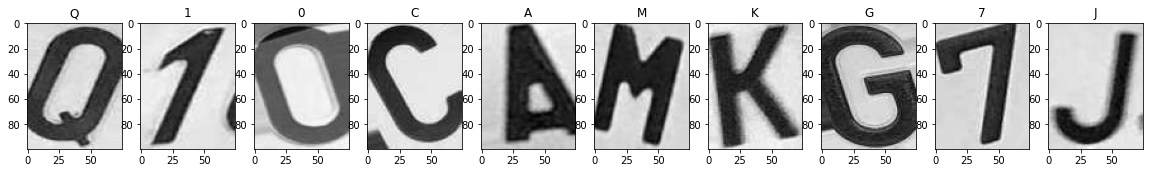

In [41]:
plot_images(images, labels, 10)

# PCA

In [42]:
from sklearn.decomposition import PCA
new_images = images[:1000]
pca = PCA(n_components=.95)
pca.fit(new_images)
images_pca = pca.transform(new_images)